# Question A1 (15 marks)

#### Design a feedforward deep neural network (DNN) which consists of **three** hidden layers of 128 neurons each with ReLU activation function, and an output layer with sigmoid activation function. Apply dropout of probability **0.2** to each of the hidden layers.

* note: some cells are non-editable and cannot be filled, but leave them untouched. Fill up only cells which are provided.

In [1]:
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from scipy.io import wavfile as wav

from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

from common_utils import set_seed, EarlyStopper

# setting seed
set_seed()

# setting print design
np.set_printoptions(formatter={"float": "{:8.4f}".format})

1. Define the model class.

In [2]:
from torch.nn.modules import dropout
from torch.nn.modules.activation import Sigmoid

class MLP(nn.Module):
    def __init__(self, no_features, no_hidden, no_labels):
        """
        Linear neuron from input to first hidden layer with
        ReLU activation function and Dropout of 0.2

        Linear neuron from first hidden layer to second hidden layer with
        ReLU activation function and Dropout of 0.2

        Linear neuron from 2nd hidden layer to 3rd hidden layer with
        ReLU activation function and Dropout of 0.2

        Linear neuron from 3rd hidden layer to output layer with
        Sigmoid activation function.
        """
        super().__init__()
        self.mlp_stack = nn.Sequential(
            # YOUR CODE HERE
            nn.Linear(no_features, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, no_hidden),
            nn.ReLU(),
            nn.Dropout(0.2),

            nn.Linear(no_hidden, no_labels),
            nn.Sigmoid(),
        )
    # YOUR CODE HERE
    def forward(self, x):
      """
      Added a forward(x) function to return logits.
      """
      logits = self.mlp_stack(x)
      return logits



#### Divide the dataset into a 70:30 ratio for training and testing. Use **appropriate** scaling of input features. We solely assume that there are only two datasets here: training & test.

1. Split the dataset and do preprocessing.

In [3]:
from common_utils import split_dataset, preprocess_dataset


def preprocess(df):
    # YOUR CODE HERE
    """
    Removed the column "filename", "label".

    Split dataset to a 0.7:0.3 ratio for training and testing, with a random state of 1.
    """
    col_to_drop = ["filename", "label"]
    x_train, y_train, x_test, y_test = split_dataset(df, col_to_drop, 0.3, 1)

    X_train_scaled, X_test_scaled = preprocess_dataset(x_train, x_test)
    return X_train_scaled, y_train, X_test_scaled, y_test



In [4]:
# Modified filepath to retrieve "simplified.csv"
# Loading csv into a dataframe,
# then pass dataframe into preprocess() to split into 4 sets,
# x_train, y_train, x_test, y_test
df = pd.read_csv('simplified.csv')
df['label'] = df['filename'].str.split('_').str[-2]
df['label'].value_counts()

X_train_scaled, y_train, X_test_scaled, y_test = preprocess(df)

In [5]:
print(X_train_scaled.shape)
print(y_train.shape)
print(X_test_scaled.shape)
print(y_test.shape)

(8439, 77)
(8439,)
(3618, 77)
(3618,)


#### Use the training dataset to train the model for 100 epochs. Use a mini-batch gradient descent with **‘Adam’** optimizer with learning rate of **0.001**, and **batch size = 256**. Implement early stopping with patience of **3**.

1. Define a Pytorch Dataset and Dataloaders.  

In [6]:
class CustomDataset(Dataset):
    # YOUR CODE HERE
    """
    Implemented the necessary functions inherited from Dataset class.
    """
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float)
        self.y = torch.tensor(y)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
      return self.X[idx], self.y[idx]


def intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test):
    # YOUR CODE HERE
    """
    Created dataset for train and test, then load them into a dataloader.
    """
    train_data = CustomDataset(X_train_scaled, y_train)
    test_data = CustomDataset(X_test_scaled, y_test)
    train_dataloader = DataLoader(train_data, batch_size=256, shuffle=True)
    test_dataloader = DataLoader(test_data, batch_size=256, shuffle=True)
    return train_dataloader, test_dataloader

train_dataloader, test_dataloader = intialise_loaders(X_train_scaled, y_train, X_test_scaled, y_test)

In [7]:
print(f"train_dataloader:\n{train_dataloader}")
print(f"test_dataloader:\n{test_dataloader}")

train_dataloader:
test_dataloader:


2. Next, define the model, optimizer and loss function.

In [8]:
# YOUR CODE HERE
no_inputs = len(X_train_scaled[0])
no_hidden = 128
no_classes = 2
# no_classes = 1

lr = 0.001
no_epochs = 100

# Initializing model with no_features = length of X_train_scaled[0]
# which is the number of columns,

# 128 neurons in the hidden layer,

# 2 neurons in the output layer
# as we are predicting either negative(0) or positive(1)
model = MLP(no_inputs, no_hidden, no_classes)

# optimizer used = "Adam" optimizer with learning rate 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Assumed to use BCELoss() as it is we are performing classification
# of either positive / negative. (2 classes only)
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.BCELoss()

# Implementing EarlyStopper Class from common_utils.py
# Set min_delta at 0.00005 to prevent early termination of training when the epoch have not fully converged yet.
early_stopper = EarlyStopper(patience=3, min_delta=0.00005)
# early_stopper = EarlyStopper(patience=3, min_delta=0)

3. Train model for 100 epochs. Record down train and test accuracies. Implement early stopping.

In [9]:
# YOUR CODE HERE
train_loss_ = []
train_acc_ = []
test_loss_ = []
test_acc_ = []

early_stop_train_loss = None
early_stop_test_loss = None

# Copied from tutorial 3 qn 2a
def train_loop(dataloader, model, loss_fn, optimizer):
    """
    Training per epoch
    """
    size = len(dataloader.dataset)
    no_batches = len(dataloader)
    train_loss, correct = 0, 0
    for batch, (X, y) in enumerate(dataloader):
        pred = model(torch.tensor(X, dtype=torch.float))
        loss = loss_fn(pred, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    # Summing train loss per batch, then dividing by the batch.
    train_loss /= size
    correct /= size
    return train_loss, correct

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    no_batches = len(dataloader)
    test_loss, correct = 0, 0

    # prevent calculation of gradient to prevent training in test.
    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= size
    correct /= size

    return test_loss, correct


In [10]:
from copy import deepcopy
track_epoch, tracked = 0, False

for epoch in range(no_epochs):
    train_loss, train_acc = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss, test_acc = test_loop(test_dataloader, model, loss_fn)

    train_loss_.append(train_loss)
    train_acc_.append(train_acc)
    test_loss_.append(test_loss)
    test_acc_.append(test_acc)

    # if epoch % 5 == 0 or epoch < 1:
    print(f"Epoch {epoch}")
    print(f"Train loss: {train_loss:12.8f}\tTrain Accuracy: {train_acc:12.8f}")
    print(f"Test loss : {test_loss:12.8f}\tTest Accuracy: {test_acc:12.8f}")

    # Used early stopper on test loss.
    # What i did here was to record where the training was stopped by early stop,
    # so i could compare the difference between early stop and if it continued training until the 100th epoch.
    # Model did continue training here.
    if early_stopper.early_stop(test_loss) and not tracked:
        tracked = True
        track_epoch = deepcopy(epoch + 1)
        early_stop_train_loss = deepcopy(train_loss_)
        early_stop_test_loss = deepcopy(test_loss_)
        early_stop_train_acc = deepcopy(train_acc_)
        early_stop_test_acc = deepcopy(test_acc_)
        print(f"Track Epoch at early stop: {track_epoch}\n\n")
        # print(f"Early Stop Train Loss size: {len(early_stop_train_loss)}")
        # print(f"Early Stop Test Loss size: {len(early_stop_test_loss)}")
        # print(f"Early Stop Train Acc size: {len(early_stop_train_acc)}")
        # print(f"Early Stop Test Acc size: {len(early_stop_test_acc)}")
        # break

<ipython-input-9-c3cbe38ecad6>:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pred = model(torch.tensor(X, dtype=torch.float))


Epoch 0
Train loss:   0.00269492	Train Accuracy:   0.53691196
Test loss :   0.00283779	Test Accuracy:   0.56246545
Epoch 1
Train loss:   0.00264470	Train Accuracy:   0.57708259
Test loss :   0.00281762	Test Accuracy:   0.57296849
Epoch 2
Train loss:   0.00260092	Train Accuracy:   0.59462022
Test loss :   0.00278245	Test Accuracy:   0.59784411
Epoch 3
Train loss:   0.00255238	Train Accuracy:   0.61594976
Test loss :   0.00272722	Test Accuracy:   0.60364842
Epoch 4
Train loss:   0.00251594	Train Accuracy:   0.63360588
Test loss :   0.00272218	Test Accuracy:   0.61028192
Epoch 5
Train loss:   0.00249024	Train Accuracy:   0.64427065
Test loss :   0.00270138	Test Accuracy:   0.63045882
Epoch 6
Train loss:   0.00243998	Train Accuracy:   0.66287475
Test loss :   0.00268165	Test Accuracy:   0.62962963
Epoch 7
Train loss:   0.00241008	Train Accuracy:   0.66808864
Test loss :   0.00269152	Test Accuracy:   0.61829740
Epoch 8
Train loss:   0.00237478	Train Accuracy:   0.68455978
Test loss :   0.00

In [11]:
w = model.state_dict()['mlp_stack.0.weight'].numpy()
b = model.state_dict()['mlp_stack.0.bias'].numpy()

V = model.state_dict()['mlp_stack.9.weight'].numpy()
c = model.state_dict()['mlp_stack.9.bias'].numpy()


# print(f"weight W:\n{w}")
# print(f"bias b:\n{b}")

print(f"Final weight and bias:")
print(f"weight V:\n{V.shape}")
print(f"bias c:\n{c.shape}")

# for item in model.state_dict():
#   print(f"Item: {item}")

Final weight and bias:
weight V:
(2, 128)
bias c:
(2,)


#### Plot train and test accuracies and losses on training and test data against training epochs and comment on the line plots.


In [12]:
# YOUR CODE HERE
def plot_training_loss(no_epochs, train_loss, test_loss, title):
  plt.figure()
  plt.plot(range(no_epochs), train_loss, label="train")
  plt.plot(range(no_epochs), test_loss, label="test")
  plt.xlabel("No. of Epochs")
  if "Loss" in title:
      plt.ylabel("Cross Entropy Loss")
  elif "Accuracy" in title:
      plt.ylabel("Accuracy")
  plt.title(title)
  plt.legend()
  plt.show()

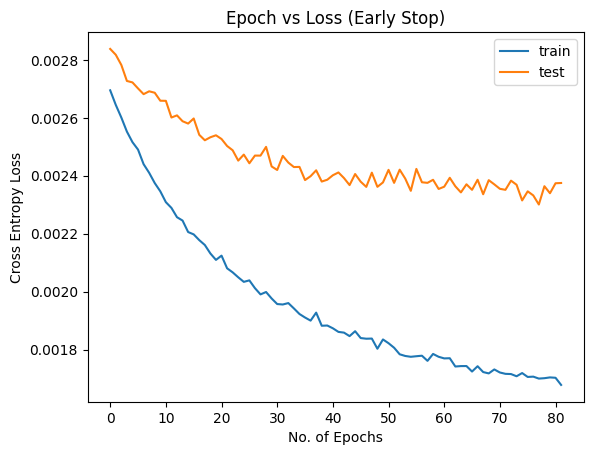

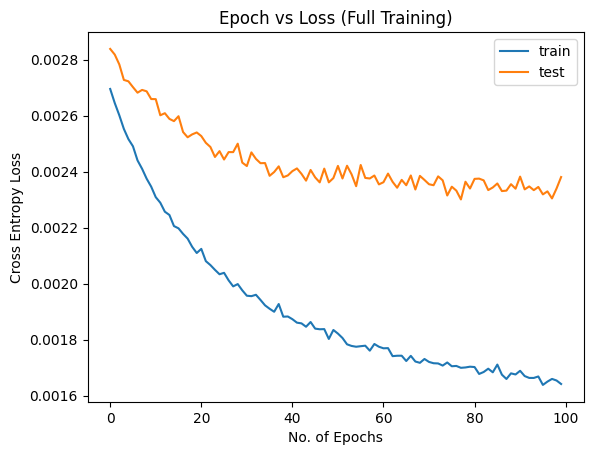

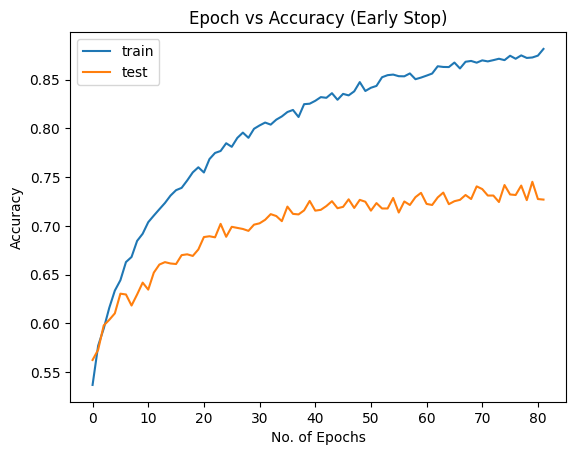

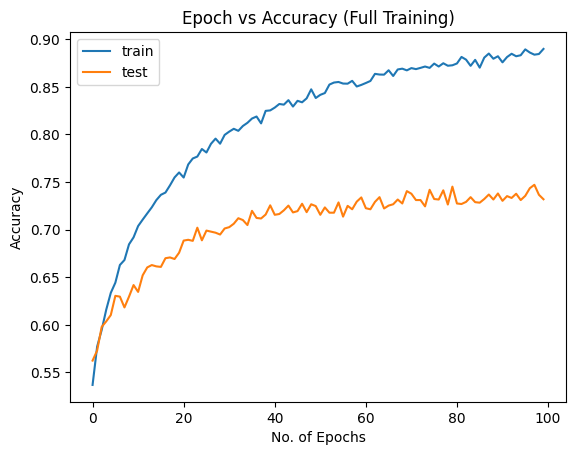

In [13]:
# Plotting Train and Test Loss with Early Stop against training epoch
if tracked == True:
    plot_training_loss(track_epoch, early_stop_train_loss, early_stop_test_loss, "Epoch vs Loss (Early Stop)")

# plotting full Train and Test Loss against full 100 training epochs.
plot_training_loss(no_epochs, train_loss_, test_loss_, "Epoch vs Loss (Full Training)")

# Plotting the Train and Test accuracy with Early Stop against training epoch.
if tracked == True:
    plot_training_loss(track_epoch, early_stop_train_acc, early_stop_test_acc, "Epoch vs Accuracy (Early Stop)")

# Plotting full Train and Test accuracy against full 100 training epochs.
plot_training_loss(no_epochs, train_acc_, test_acc_, "Epoch vs Accuracy (Full Training)")

2. Comment on line plots.

In [14]:
# YOUR CODE HERE
answer = """
For the Cross Entropy Loss vs No. of Epochs implemented with early stopping,
we can see that despite the training loss still decreasing,
the test loss started increasing / did not go below the minimum test loss before it resets the patience for early stopping.
This might be an indication of an overfitting model.
For the Accuracy vs Epoch plot, we can observe that despite starting off with similar accuracies at the beginning of the training,
the test accuracy is not performing as well as the train accuracy as well.
This also shows that there might be a chance of the model overfitting as
the model might be too fitted to the training dataset that it does not perform well on the test dataset.

However, due to early stopping, the model stops training before it begins to overfit.

The reasons for the model starting to overfit might be due to the number of hidden neurons in the hidden layers.
For each hidden layer, there are 128 neurons, which might lead to the model learning too accurately according to the training dataset.
This would result in the model performing well in training,
as we can see from the graph with its high accuracy and low cross entropy loss,
but it will not perform well on the test dataset as it is too fitted to the training dataset.
"""